<a href="https://colab.research.google.com/github/SoudruhRomanCZ/KRIVANEK-240642-MLF/blob/main/Project/Kopie_se%C5%A1itu_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROJEKT**

#0. Import needed libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

Mounted at /content/drive


#1. data preprocesing
## 1.1 Importing data

In [2]:
print(os.listdir('/content/drive/MyDrive/MPA-MLF-Project_data'))

['test_format.csv', 'label_train.csv', 'Test', 'Train']


In [3]:
# Set the path to your data
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/MPA-MLF-Project_data'


# Load the CSV files
label_train = pd.read_csv(os.path.join(data_path, 'label_train.csv'))
test_format = pd.read_csv(os.path.join(data_path, 'test_format.csv'))

# Load all NPY files from the Train directory
train_data = []
for i in range(1491):  # Assuming files are named from 0.npy to 1490.npy
    file_path = os.path.join(data_path, 'Train', f'{i}.npy')
    if os.path.exists(file_path):
        data = np.load(file_path)
        train_data.append(data)

# Convert list to a NumPy array
train_data = np.array(train_data)

# Load all NPY files from the Test directory
test_data = []
for i in range(120):  # Assuming files are named from 0.npy to 119.npy
    file_path = os.path.join(data_path, 'Test', f'{i}.npy')
    if os.path.exists(file_path):
        data = np.load(file_path)
        test_data.append(data)

# Convert list to a NumPy array
test_data = np.array(test_data)

# Display the shapes of the loaded data
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train data shape: (1491, 72, 48)
Test data shape: (120, 72, 48)


In [4]:
print(train_data[0])
print(test_data[0])
print(label_train)
print(test_format)

[[-42.94846208 -34.19988488 -30.69119585 ... -43.47883062 -31.54647995
  -45.9194625 ]
 [-41.86518571 -34.80668569 -41.2543513  ... -43.86449976 -30.51855427
  -42.34268155]
 [-44.17245767 -30.68308296 -46.65993373 ... -31.69508203 -35.44104458
  -52.93088205]
 ...
 [-54.30841153 -34.66132862 -34.0509651  ... -43.77111016 -22.20773064
  -33.01597406]
 [-57.27087524 -22.44226418 -40.00710921 ... -35.46174065 -32.99610352
  -40.59258701]
 [-49.27546527 -32.22061918 -31.86473242 ... -31.3190966  -36.97273765
  -36.31152144]]
[[-11.25314668 -31.84428476 -22.68082809 ... -22.52479543 -32.91363933
  -29.65546479]
 [-21.6004675  -37.93874162 -19.49501801 ... -24.53372017 -25.91555421
  -33.29106494]
 [-12.72565979 -19.45708105 -24.2567116  ... -24.55794644 -26.70381511
  -34.58798993]
 ...
 [-20.83848579 -20.17628113 -27.87154065 ... -13.50993688 -23.19541761
  -30.58345256]
 [  0.5148323  -22.00535833 -18.17926808 ... -20.55218552 -28.46280408
  -26.58848488]
 [-19.46380877 -18.83375454 -19.

##1.2 Preprocesing data

In [5]:
def data_augm(dataset: np.array, dataset_labels: np.array, awgn_std: int) -> tuple:
    bts_0 = dataset[dataset_labels == 0]
    bts_1 = dataset[dataset_labels == 1]
    bts_2 = dataset[dataset_labels == 2]
    #mean = np.mean(dataset)
    for k in range(2):
        bts_0 = bts_0 + np.random.normal(0, awgn_std + 2*k, (bts_0.shape[0], bts_0.shape[1], bts_0.shape[2])) #adding AWGN
        dataset = np.append(dataset, bts_0, 0)
        dataset_labels = np.append(dataset_labels, np.zeros(bts_0.shape[0]))

    num_of_bts0 = np.count_nonzero(dataset_labels == 0)

    for k in range(num_of_bts0//bts_1.shape[0]):
        bts_1 = bts_1 + np.random.normal(0, awgn_std + k//3, (bts_1.shape[0], bts_1.shape[1], bts_1.shape[2])) #adding AWGN
        dataset = np.append(dataset, bts_1, 0)
        dataset_labels = np.append(dataset_labels, np.ones(bts_1.shape[0]))

    for k in range(num_of_bts0//bts_2.shape[0] ):
        bts_2 = bts_2 + np.random.normal(0, awgn_std + k//3, (bts_2.shape[0], bts_2.shape[1], bts_2.shape[2])) #adding AWGN
        dataset = np.append(dataset, bts_2, 0)
        dataset_labels = np.append(dataset_labels, 2 * np.ones(bts_2.shape[0]))

    return dataset, dataset_labels

In [6]:
y_label = label_train["target"].values  # Extrahujeme správný sloupec
y_test_label = test_format["target"].values   # Testovací štítky
train_data, y_label = data_augm(train_data,y_label,3)

# Rozdělení dat s rovnoměrným zastoupením tříd
X_train, X_test, y_train, y_test = train_test_split(
    train_data,
    y_label,
    test_size=0.2,
    random_state=42,
)

print(y_label)
print(y_test_label)

[0. 0. 0. ... 2. 2. 2.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [7]:
# Přetvarujeme data tak, aby každý vzorek byl jedním řádkem (3456 = 72*48)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
test_data_reshaped = test_data.reshape(test_data.shape[0], -1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)
test_data_scaled = scaler.transform(test_data_reshaped)

# Vracíme data zpět do původního 2D tvaru
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)
test_data_scaled = test_data_scaled.reshape(test_data.shape)

print(test_data_scaled.shape)
print(X_train_scaled.shape)
print(X_test_scaled.shape)


(120, 72, 48)
(8767, 72, 48)
(2192, 72, 48)


In [8]:
X_train_final = X_train_scaled[..., np.newaxis]  # tvar (1491, 72, 48, 1)
X_test_final = X_test_scaled[..., np.newaxis]

In [9]:
y_train_encoded = to_categorical(y_train, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

print(y_train_encoded.shape)
print(y_test_encoded.shape)

(8767, 3)
(2192, 3)


#2. Model Selection and Implementation

In [10]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(72, 48, 1), padding='same'),
    MaxPooling2D((2,2)),

    Flatten(),
    #Dropout(0.5),  # Tento ponechej
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])


model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 72, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 27648)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,539,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,539,779 (13.50 MB)

 Trainable params: 3,539,779 (13.50 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(1.0115380177685473), 1: np.float64(0.9980646630236795), 2: np.float64(0.9906214689265537)}


#3. Model Training

In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_final, y_train_encoded,
                    validation_data=(X_test_final, y_test_encoded),
                    epochs=20,
                    batch_size=33,
                    class_weight=class_weights,
                    callbacks=[early_stop]
                    )

Epoch 1/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 35s 124ms/step - accuracy: 0.8001 - loss: 0.5277 - val_accuracy: 0.9840 - val_loss: 0.0658
Epoch 2/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 37s 112ms/step - accuracy: 0.9879 - loss: 0.0533 - val_accuracy: 0.9964 - val_loss: 0.0238
Epoch 3/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 43s 120ms/step - accuracy: 0.9970 - loss: 0.0206 - val_accuracy: 0.9982 - val_loss: 0.0129
Epoch 4/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 39s 114ms/step - accuracy: 0.9992 - loss: 0.0115 - val_accuracy: 0.9995 - val_loss: 0.0104
Epoch 5/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 40s 111ms/step - accuracy: 0.9996 - loss: 0.0076 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 6/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 30s 113ms/step - accuracy: 0.9996 - loss: 0.0046 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 7/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 8/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 41s 113ms/step - accuracy: 1.0000 - loss: 0

#4. Model Evaluation

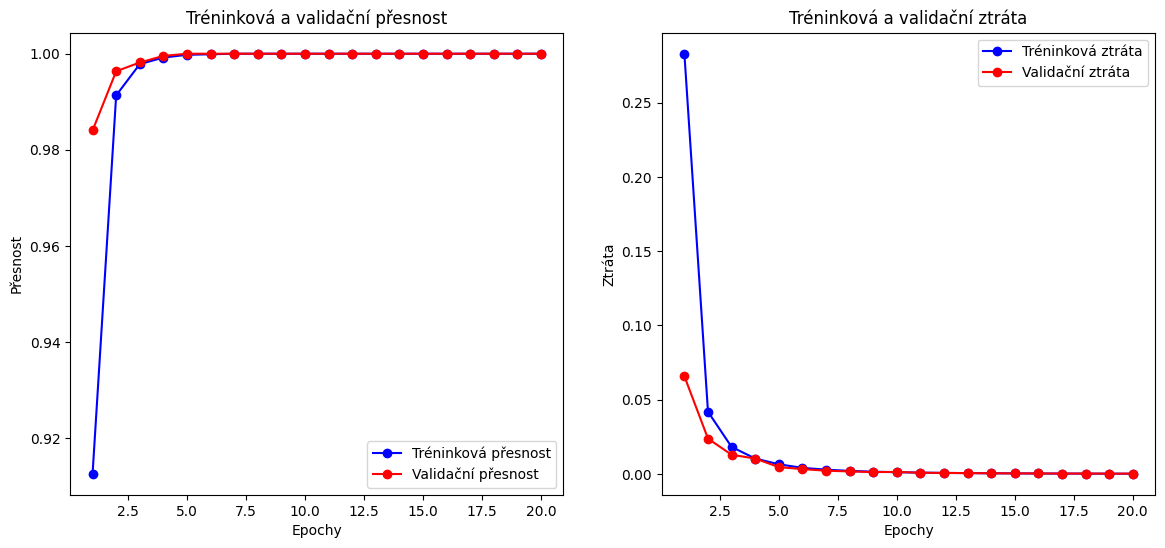

In [13]:
# Získání metrik z objektu history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Počet epoch
epochs = range(1, len(acc) + 1)

# Vykreslení přesnosti
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Tréninková přesnost')
plt.plot(epochs, val_acc, 'ro-', label='Validační přesnost')
plt.title('Tréninková a validační přesnost')
plt.xlabel('Epochy')
plt.ylabel('Přesnost')
plt.legend()

# Vykreslení ztráty
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Tréninková ztráta')
plt.plot(epochs, val_loss, 'ro-', label='Validační ztráta')
plt.title('Tréninková a validační ztráta')
plt.xlabel('Epochy')
plt.ylabel('Ztráta')
plt.legend()

plt.show()

#5. Hyperparameter Tuning

#6. Conclusion



In [14]:
y_pred = model.predict(X_test_final)
cm = confusion_matrix(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred, axis=1))
print(cm)
print()
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
print()
print(np.unique(np.argmax(y_test_encoded, axis=1), return_counts=True))
print(np.unique(np.argmax(y_train_encoded, axis=1), return_counts=True))
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(model.predict(X_test_final), axis=1)))

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
[[738   0   0]
 [  0 738   0]
 [  0   0 716]]

{np.float64(0.0): np.int64(2889), np.float64(1.0): np.int64(2928), np.float64(2.0): np.int64(2950)}

(array([0, 1, 2]), array([738, 738, 716]))
(array([0, 1, 2]), array([2889, 2928, 2950]))
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       738
           1       1.00      1.00      1.00       738
           2       1.00      1.00      1.00       716

    accuracy                           1.00      2192
   macro avg       1.00      1.00      1.00      2192
weighted avg       1.00      1.00      1.00      2192



In [16]:
test_data_final = test_data_scaled[..., np.newaxis]  # přidá kanál: (120, 72, 48, 1)
print(test_data_final.shape)  # ověř: (120, 72, 48, 1)

pred = model.predict(test_data_final)

array_to_save = np.vstack((np.arange(0, 119 + 1), np.argmax(pred, axis=1))).astype(np.int16)
np.savetxt("my_guess.csv", array_to_save.transpose(),"%d", ",", header="ID,target", comments="")


(120, 72, 48, 1)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
